In [1]:
import math
import random

import pymunk
from shapely.geometry import LineString, Polygon
from shapely.ops import unary_union
from shapely.affinity import translate, rotate
from tqdm import tqdm

In [78]:
def make_random_poly():
    """Create random lines, buffer them, and then union them to form a random polygon."""

    minx, miny, maxx, maxy = 0, 0, 100, 100
    buffer_amount = 20
    n_lines = 3

    lines = []

    for i in range(n_lines):
        x1, y1 = random.randint(minx, maxx), random.randint(miny, maxy)
        x2, y2 = random.randint(minx, maxx), random.randint(miny, maxy)
        lines.append(LineString([(x1, y1), (x2, y2)]))
    
    poly = unary_union(lines).buffer(buffer_amount, quad_segs=1)

    while not isinstance(poly, Polygon):
        poly = poly.geoms[0]

    return poly

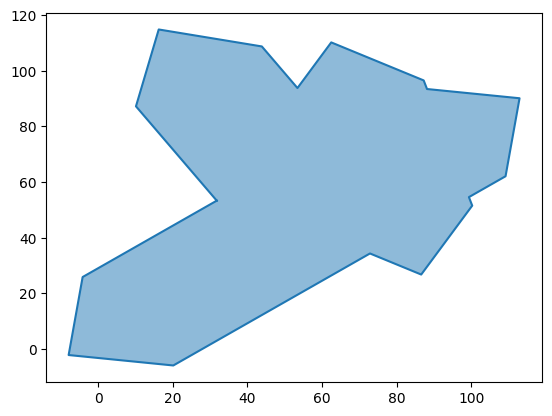

In [4]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

poly = make_random_poly()

# Show the polygon
x,y = poly.exterior.xy
plt.figure()
plt.plot(x, y)
plt.fill(x, y, alpha=0.5)  # Fill the polygon with a semi-transparent color
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 7272.72it/s]


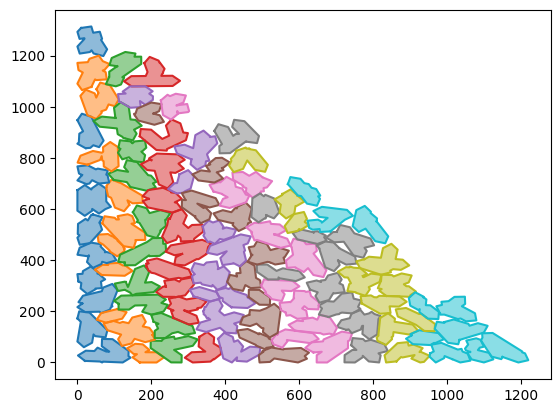

In [79]:
n_polys = 100

shapely_polys = [make_random_poly() for _ in tqdm(range(n_polys))]

body_to_shapely = {}

columns = math.ceil(math.sqrt(n_polys))

space = pymunk.Space()
space.gravity = -100, -100

walls = [(-100, -100, 100, 2000), (-100, -100, 2000, 100)]
for wall in walls:
    body = pymunk.Body(body_type=pymunk.Body.STATIC)
    # Shape is a AA box, where wall is x, y, width, height
    shape = pymunk.Poly.create_box(body, size=(wall[2], wall[3]))
    body.position = wall[0] + wall[2] / 2, wall[1] + wall[3] / 2
    shape.elasticity = 1
    shape.friction = 0.1
    space.add(body, shape)

for i, poly in enumerate(shapely_polys):
    body = pymunk.Body()
    body.position = i % columns * 130 + 50, i // columns * 130 + 50
    body.center_of_gravity = (poly.centroid.x, poly.centroid.y)
    shape = pymunk.Poly(body, [(p[0], p[1]) for p in poly.exterior.coords[:-1]], radius=0.0)
    shape.mass = 1
    shape.friction = 0.1
    space.add(body, shape)
    body_to_shapely[body] = poly

for _ in tqdm(range(1000)):
    space.step(.01)

# Show the polygons
plt.figure()

for body, poly in body_to_shapely.items():
    # Get the coordinates and rotation of the body, apply it to the original poly and render that
    transformed_poly = rotate(poly, math.degrees(body.angle), origin=(0, 0))
    transformed_poly = translate(transformed_poly, xoff=body.position.x, yoff=body.position.y)
    x, y = transformed_poly.exterior.xy
    plt.plot(x, y)
    plt.fill(x, y, alpha=0.5)  # Fill the polygon with a semi-transparent color

plt.show()


100%|██████████| 10/10 [00:00<00:00, 2503.17it/s]


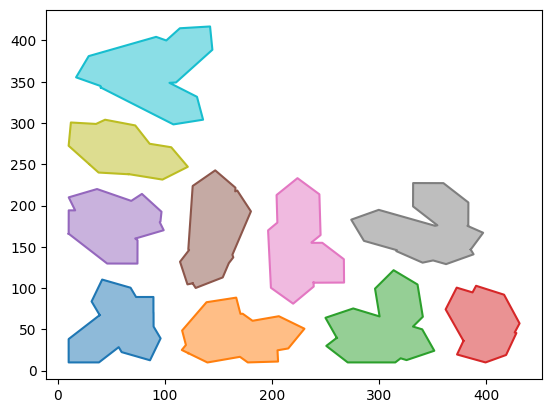

In [82]:
import math
import pymunk
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from shapely.affinity import rotate, translate
from tqdm import tqdm
import numpy as np
from IPython.display import HTML

n_polys = 10
shapely_polys = [make_random_poly() for _ in tqdm(range(n_polys))]

shapely_polys = [rotate(p, 45, origin=(50, 50)) for p in shapely_polys]

body_to_shapely = {}
columns = math.ceil(math.sqrt(n_polys))

space = pymunk.Space()
space.gravity = -100, -100

margin = 10

walls = [(-100, -100, 100, 2000), (-100, -100, 2000, 100)]
for wall in walls:
    body = pymunk.Body(body_type=pymunk.Body.STATIC)
    # Shape is a AA box, where wall is x, y, width, height
    shape = pymunk.Poly.create_box(body, size=(wall[2], wall[3]))
    body.position = wall[0] + wall[2] / 2, wall[1] + wall[3] / 2
    shape.elasticity = 1
    shape.friction = 0.1
    space.add(body, shape)

for i, poly in enumerate(shapely_polys):
    body = pymunk.Body()
    body.position = i % columns * 100 + 50, i // columns * 100 + 50
    expanded_poly = poly.buffer(margin)
    shape = pymunk.Poly(body, [(p[0], p[1]) for p in expanded_poly.exterior.coords[:-1]], radius=0.0)
    shape.mass = 1
    shape.friction = 0.1
    body.center_of_gravity = (poly.centroid.x, poly.centroid.y)
    space.add(body, shape)
    body_to_shapely[body] = poly

# Create a figure and axis for the animation
fig, ax = plt.subplots()

# Function to update the frame
def update(frame):
    ax.clear()
    for body, poly in body_to_shapely.items():
        transformed_poly = rotate(poly, math.degrees(body.angle), origin=(0, 0))
        transformed_poly = translate(transformed_poly, xoff=body.position.x, yoff=body.position.y)
        x, y = transformed_poly.exterior.xy
        ax.plot(x, y)
        ax.fill(x, y, alpha=0.5)  # Fill the polygon with a semi-transparent color
    
    # Step the simulation
    for i in range(10):
        space.step(0.01)

# Create the animation
ani = FuncAnimation(fig, update, frames=range(50), repeat=False)

HTML(ani.to_jshtml())
